In [ ]:
# !pip install torch -q
# !pip install scikit-learn -q 

In [1]:
import torch
import random
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Preprocessing data

In [2]:
data = pd.read_csv('/kaggle/input/apple-daily-dataset/AAPL_day_new.csv')
data.tail()

,Date,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
3792,2025-01-30,238.407871,240.525538,236.949483,237.329056,55658300,239.744405,236.706177,51.292711,-2.704714,-3.445377,251.151412,218.947722
3793,2025-01-31,246.918527,246.918527,233.183628,235.740814,101075100,239.964164,236.668320,49.385834,-2.320950,-3.220492,248.879821,219.778898
3794,2025-02-03,229.737419,231.575395,225.452122,227.759583,73063300,239.963964,236.318957,41.114113,-2.630510,-3.102495,247.705859,219.370598
3795,2025-02-04,227.000419,232.873966,226.401072,232.544327,45067300,240.054265,236.170933,46.860376,-2.461376,-2.974271,246.484818,219.536799
3796,2025-02-05,228.279016,232.414468,228.019307,232.214691,39620300,240.123589,236.015786,46.523548,-2.327110,-2.844839,244.739628,220.030366


In [3]:
def preprocessing(data, flag=True):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if flag:
        scaler = MinMaxScaler()
        data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

In [4]:
apple_stock = preprocessing(data)
data = pd.read_csv('/kaggle/input/apple-daily-dataset/AAPL_day_new.csv')
apple_stock_without_normalizing = preprocessing(data, False)
apple_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3797 entries, 2010-01-04 to 2025-02-05
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3797 non-null   float64
 1   High         3797 non-null   float64
 2   Low          3797 non-null   float64
 3   Close        3797 non-null   float64
 4   Volume       3797 non-null   float64
 5   SMA          3797 non-null   float64
 6   EMA          3797 non-null   float64
 7   RSI          3797 non-null   float64
 8   MACD         3797 non-null   float64
 9   MACD_Signal  3797 non-null   float64
 10  BB_Upper     3797 non-null   float64
 11  BB_Lower     3797 non-null   float64
dtypes: float64(12)
memory usage: 385.6 KB


<ipython-input-3-86a397dbe36d>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-86a397dbe36d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-3-86a397dbe36d>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-86a397dbe36d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [5]:
apple_stock.tail()

,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2025-01-30,0.922661,0.924035,0.918936,0.915375,0.017453,0.998379,0.982193,0.434400,0.246585,0.159486,0.948673,0.908999
2025-01-31,0.956418,0.949212,0.903969,0.909096,0.041900,0.999318,0.982031,0.407028,0.271446,0.175590,0.939876,0.912541
2025-02-03,0.888270,0.888786,0.873243,0.877544,0.026822,0.999318,0.980542,0.288293,0.251392,0.184039,0.935330,0.910801
2025-02-04,0.877414,0.893900,0.877014,0.896460,0.011752,0.999704,0.979911,0.370777,0.262349,0.193221,0.930602,0.911509
2025-02-05,0.882486,0.892091,0.883445,0.895156,0.008820,1.000000,0.979249,0.365942,0.271047,0.202489,0.923844,0.913613


# DataLoader

In [6]:
BATCH_SIZE = 64
SEQUENCE_LENGTH = 10

In [7]:
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  
        label = targets[i + sequence_length] 
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    sequences = np.transpose(sequences, (0, 2, 1))  
    return sequences, labels

In [8]:
def prepare_dataloaders(data, feature_columns, target_column, sequence_length, batch_size, test_size=0.1):
    X = data[feature_columns].values
    y = data[target_column].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, shuffle=False)
    
    x_train, y_train = create_sequences(X_train, Y_train, sequence_length)
    x_val, y_val = create_sequences(X_val, Y_val, sequence_length)
    x_test, y_test = create_sequences(X_test, Y_test, sequence_length)
    
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader, y_test

In [9]:
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower']
# train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, BATCH_SIZE)

# FractalNet

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, drop_prob, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.dropout = nn.Dropout(drop_prob)
        self.batchnorm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.dropout(out)
        out = self.batchnorm(out)
        out = F.relu(out)
        return out


class FractalBlock(nn.Module):
    def __init__(self, n_columns, input_channels, output_channels, kernel_size, local_drop_prob, dropout_prob,
                 global_drop_prob, training=True):
        super().__init__()
        self.n_columns = n_columns
        self.columns = nn.ModuleList([nn.ModuleList() for _ in range(n_columns)])
        self.max_depth = 2 ** (n_columns - 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob
        self.count = np.zeros([self.max_depth], dtype=int)
        
        dist = self.max_depth
        for col in self.columns:
            for i in range(self.max_depth):
                if (i + 1) % dist == 0:
                    first_block = (i + 1 == dist)
                    if first_block:
                        cur_input = input_channels
                    else:
                        cur_input = output_channels

                    module = ConvBlock(cur_input, output_channels, kernel_size, dropout_prob)
                    self.count[i] += 1
                else:
                    module = None
                col.append(module)
            dist //= 2

    def drop_mask(self, B, global_cols, n_cols):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if isinstance(global_cols, np.ndarray):
            global_cols = torch.tensor(global_cols, device=device)
        
        GB = global_cols.shape[0]
        gdrop_cols = global_cols - (self.n_columns - n_cols)
        gdrop_indices = torch.where(gdrop_cols >= 0)[0]
        
        gdrop_mask = torch.zeros(n_cols, GB, device=device, dtype=torch.float32)
        if gdrop_indices.shape[0] > 0:
            gdrop_mask[gdrop_cols[gdrop_indices], gdrop_indices] = 1.0
        
        LB = B - GB
        prob_tensor = torch.ones(n_cols, LB, device=device) * (1. - self.local_drop_prob)
        ldrop_mask = torch.bernoulli(prob_tensor)
        alive_count = ldrop_mask.sum(dim=0)
        
        dead_indices = torch.where(alive_count == 0.)[0]
        if dead_indices.shape[0] > 0:
            random_rows = torch.randint(0, n_cols, (dead_indices.shape[0],), device=device)
            ldrop_mask[random_rows, dead_indices] = 1.0
        drop_mask = torch.cat((gdrop_mask, ldrop_mask), dim=1)
        return drop_mask

    def join(self, outs, global_cols):
        n_cols = len(outs)
        out = torch.stack(outs) 

        if self.training:
            mask = self.drop_mask(out.size(1), global_cols, n_cols).to(out.device)  # [n_cols, B]
            mask = mask.view(*mask.size(), 1, 1) 
            n_alive = mask.sum(dim=0)  
            masked_out = out * mask  
            n_alive[n_alive == 0.] = 1.
            out = masked_out.sum(dim=0) / n_alive  
        else:
            out = out.mean(dim=0)
        return out

    def forward(self, x, global_cols):
        outs = [x] * self.n_columns
        for i in range(self.max_depth):
            st = self.n_columns - self.count[i]
            cur_outs = []

            for c in range(st, self.n_columns):
                cur_in = outs[c]
                cur_module = self.columns[c][i]
                if cur_module is not None:
                    cur_outs.append(cur_module(cur_in))

            joined = self.join(cur_outs, global_cols)

            for c in range(st, self.n_columns):
                outs[c] = joined

        outs[-1] = self.dropout(outs[-1])
        return outs[-1]


class FractalNet(nn.Module):
    def __init__(self, n_blocks, n_columns, input_channels, out_channels, kernel_size, local_drop_prob, drop_prob,
                 global_drop_prob):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_columns = n_columns
        self.input_channels = input_channels
        self.out_channels = out_channels
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob

        self.layers = nn.ModuleList()
        total_layers = 0

        current_channels = input_channels
        for i in range(self.n_blocks):
            print(f"Block {i + 1}, Input channels: {current_channels}, Output channels: {out_channels[i]}")
            fractal_block = FractalBlock(n_columns, current_channels, out_channels[i], kernel_size, local_drop_prob,
                                         drop_prob,
                                         global_drop_prob)
            self.layers.append(fractal_block)
            self.layers.append(nn.BatchNorm1d(out_channels[i]))
            if i < self.n_blocks - 1:
                self.layers.append(nn.AvgPool1d(2))
            else:
                self.layers.append(nn.AdaptiveAvgPool1d(1))
            total_layers += fractal_block.max_depth
            current_channels = out_channels[i]
    
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(out_channels[-1], 1))
        self.initialize_weights()

        print(f"Total layers in network: {total_layers}")

    def initialize_weights(self):
        for name, param in self.named_parameters():
            if param.dim() > 1:  
                nn.init.xavier_uniform_(param)
            else: 
                if 'bn.weight' in name:
                    nn.init.ones_(param)
                elif 'bn.bias' in name or 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        GB = int(x.size(0) * self.global_drop_prob)
        global_cols = None
        out = x

        for layer in self.layers:
            if isinstance(layer, FractalBlock):
                global_cols = np.random.randint(0, self.n_columns, size=[GB])
                out = layer(out, global_cols)
            else:
                out = layer(out)
        return out

In [11]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            all_targets.append(targets.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            
    avg_loss = total_loss / len(dataloader.dataset)
    targets = np.concatenate(all_targets)
    outputs = np.concatenate(all_outputs)
    
    mse = np.mean((outputs - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    
    return avg_loss, rmse, mae

In [12]:
def plot_metrics(predictions, targets, name):
    
    predictions_natural = predictions.flatten()
    targets_natural = targets.flatten() 

    plt.figure(figsize=(10, 6))
    plt.plot(targets_natural, label="Real Values", color='blue')
    plt.plot(predictions_natural, label="Predicted Values", color='red', linestyle='dashed')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Real vs Predicted Values')
    plt.legend()
    plt.savefig(name, dpi=99) 
    plt.show()

In [13]:
def evaluate_on_test(model, test_dataloader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            # print("targets", targets)
            # print("Prediction", outputs)
            loss = criterion(outputs, targets)  
            test_loss += loss.item() * inputs.size(0) 
            
            all_predictions.append(outputs.cpu().numpy())  
            all_targets.append(targets.cpu().numpy())
    
    test_loss /= len(test_dataloader.dataset)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return all_predictions

In [17]:
def train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets_test, model, criterion, optimizer, num_epochs, device, name_model, png):
    model.to(device)
    best_val_loss = float('inf')
    
    train_rmse_list, train_mae_list = [], []
    val_rmse_list, val_mae_list = [], []
    train_loss_list, val_loss_list = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_train_targets = []
        all_train_outputs = []
        
        batch_inputs = []
        batch_targets = []
        
        for inputs, targets in train_dataloader:
            batch_inputs.append(inputs.to(device))
            batch_targets.append(targets.float().to(device))
            
        inputs = torch.cat(batch_inputs)
        targets = torch.cat(batch_targets)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        outputs = outputs.view_as(targets)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item() * inputs.size(0)
        all_train_targets.append(targets.cpu().detach().numpy())
        all_train_outputs.append(outputs.cpu().detach().numpy())
        
        train_targets = np.concatenate(all_train_targets)
        train_outputs = np.concatenate(all_train_outputs)
        
        train_mse = np.mean((train_outputs - train_targets) ** 2)
        train_rmse = np.sqrt(train_mse)
        train_mae = np.mean(np.abs(train_outputs - train_targets))
        
        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_loss_list.append(train_loss / len(train_dataloader.dataset))
        
        val_loss, val_rmse, val_mae = evaluate_model(model, val_dataloader, criterion, device)
        val_rmse_list.append(val_rmse)
        val_mae_list.append(val_mae)
        val_loss_list.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), name_model)

        if ((epoch + 1) % 100) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
            print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')
    
    torch.save(model.state_dict(), name_model)
    test_loss, test_rmse, test_mae = evaluate_model(model, test_dataloader, criterion, device)
    predictions = evaluate_on_test(model, test_dataloader, criterion, device)
    print('\nFinal Results:')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    plot_metrics(predictions, targets_test, png)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [15]:
def seed_everything(seed_value=0):
    random.seed(seed_value)  
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value) 
    torch.cuda.manual_seed(seed_value) 
    torch.cuda.manual_seed_all(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

# Without Normalizing

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 49.9273, Train MAE: 40.1571
Val RMSE: 105.7674, Val MAE: 104.8243
Epoch 200/400:
Train RMSE: 44.3684, Train MAE: 36.0251
Val RMSE: 90.1472, Val MAE: 87.6998
Epoch 300/400:
Train RMSE: 36.7321, Train MAE: 28.5703
Val RMSE: 83.0401, Val MAE: 79.2137
Epoch 400/400:
Train RMSE: 29.4144, Train MAE: 20.8485
Val RMSE: 71.0135, Val MAE: 65.8650

Final Results:
Test RMSE: 101.7766
Test MAE: 93.6007


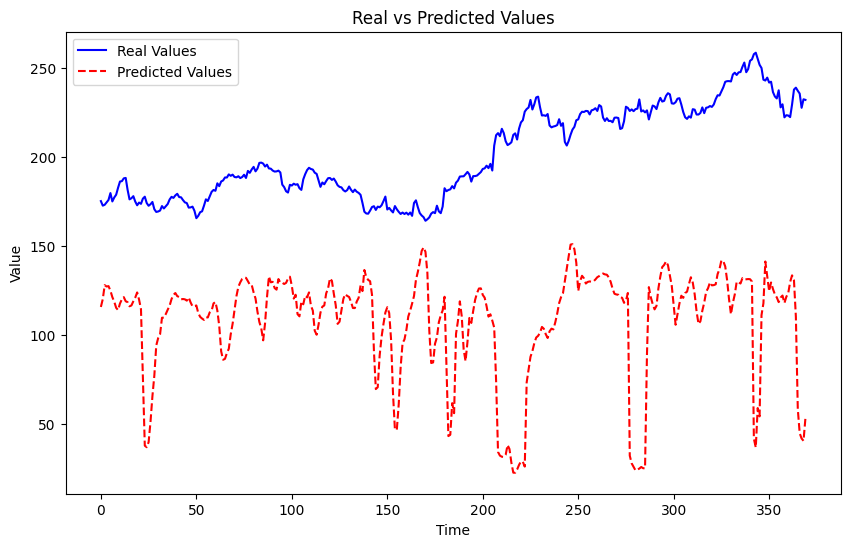

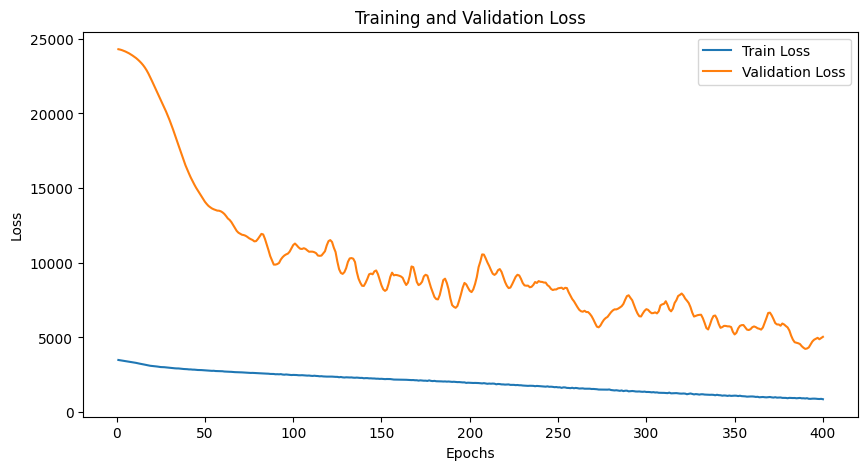

In [18]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock_without_normalizing, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_without_norm.pth', 'without_norm.png')

# LR = 0.0001

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.5623, Train MAE: 0.2439
Val RMSE: 0.3935, Val MAE: 0.3886
Epoch 200/400:
Train RMSE: 0.4812, Train MAE: 0.2058
Val RMSE: 0.3397, Val MAE: 0.3345
Epoch 300/400:
Train RMSE: 0.4566, Train MAE: 0.1893
Val RMSE: 0.2979, Val MAE: 0.2926
Epoch 400/400:
Train RMSE: 0.4117, Train MAE: 0.1699
Val RMSE: 0.2682, Val MAE: 0.2626

Final Results:
Test RMSE: 0.3243
Test MAE: 0.3165


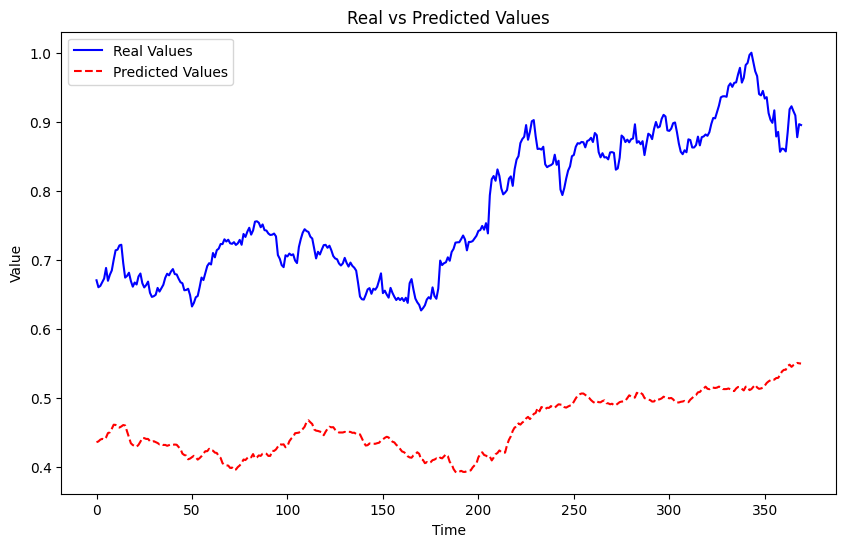

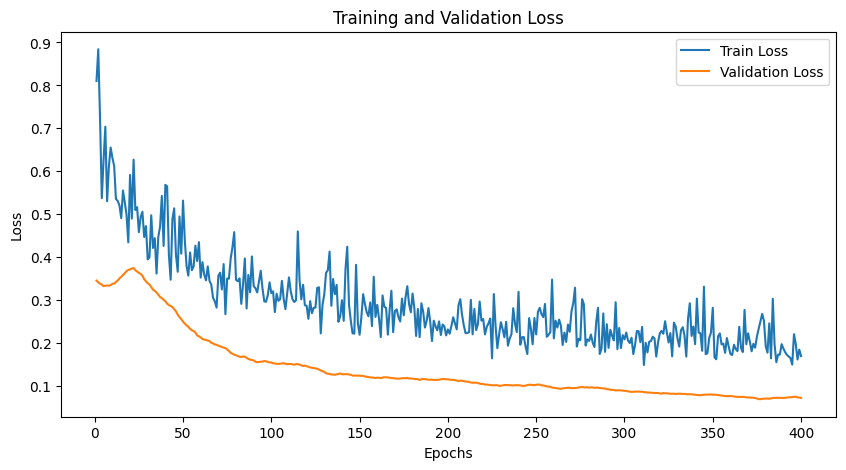

In [19]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_lr_0001.pth', 'lr_0001.png')

# LR = 0.001

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3319, Train MAE: 0.1328
Val RMSE: 0.1312, Val MAE: 0.1231
Epoch 200/400:
Train RMSE: 0.2711, Train MAE: 0.1014
Val RMSE: 0.0517, Val MAE: 0.0425
Epoch 300/400:
Train RMSE: 0.2466, Train MAE: 0.0790
Val RMSE: 0.0479, Val MAE: 0.0396
Epoch 400/400:
Train RMSE: 0.1378, Train MAE: 0.0592
Val RMSE: 0.0619, Val MAE: 0.0513

Final Results:
Test RMSE: 0.1173
Test MAE: 0.1067


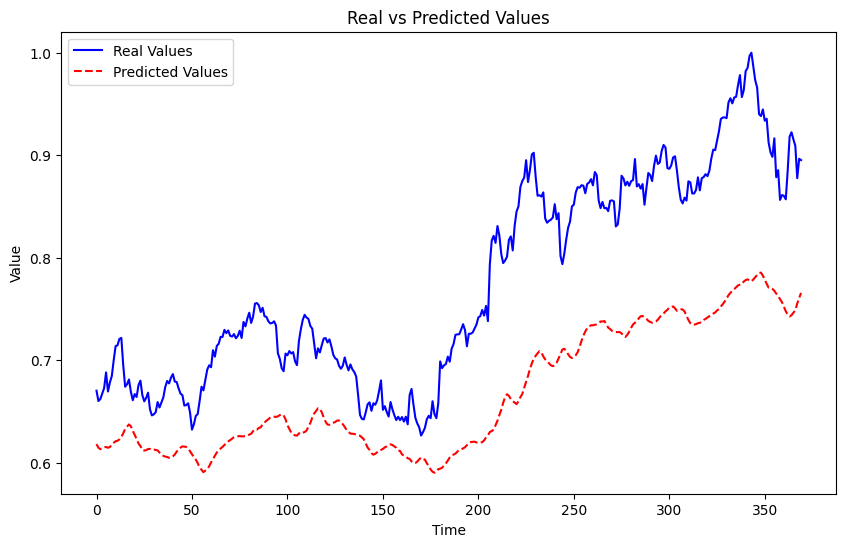

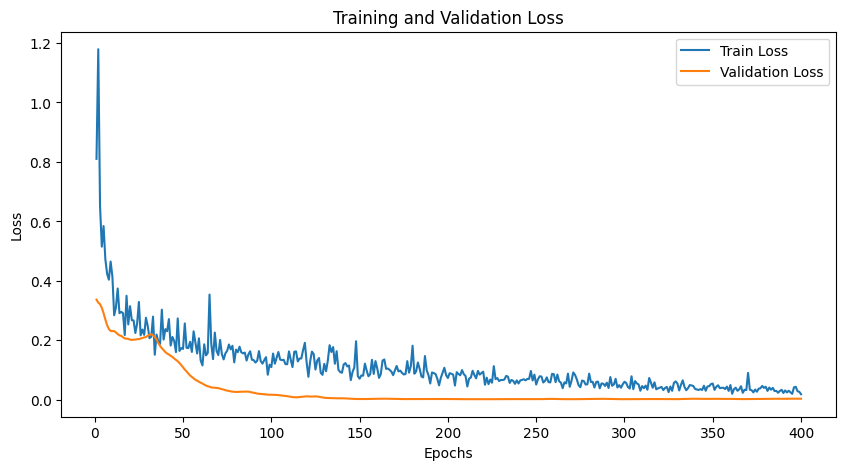

In [20]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_lr_001.pth', 'lr_001.png')

# Dropout = 0.1

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3319, Train MAE: 0.1328
Val RMSE: 0.1312, Val MAE: 0.1231
Epoch 200/400:
Train RMSE: 0.2711, Train MAE: 0.1014
Val RMSE: 0.0517, Val MAE: 0.0425
Epoch 300/400:
Train RMSE: 0.2466, Train MAE: 0.0790
Val RMSE: 0.0479, Val MAE: 0.0396
Epoch 400/400:
Train RMSE: 0.1378, Train MAE: 0.0592
Val RMSE: 0.0619, Val MAE: 0.0513

Final Results:
Test RMSE: 0.1173
Test MAE: 0.1067


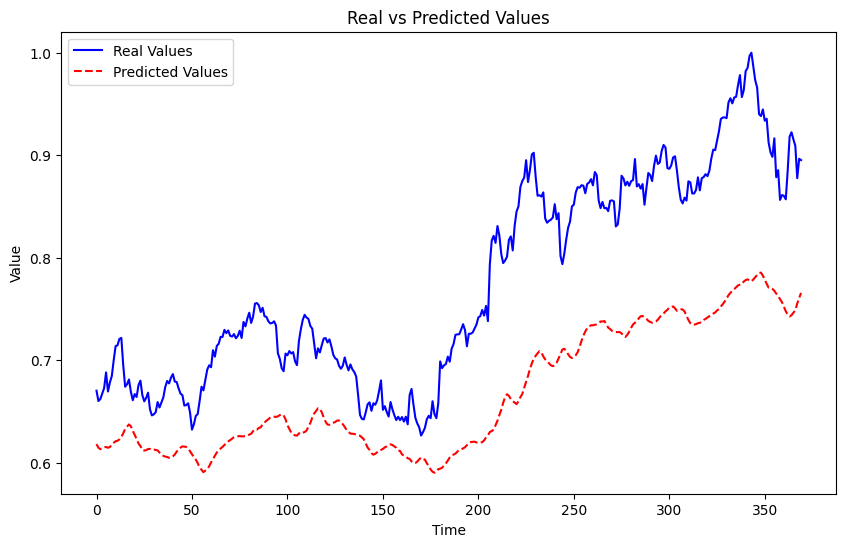

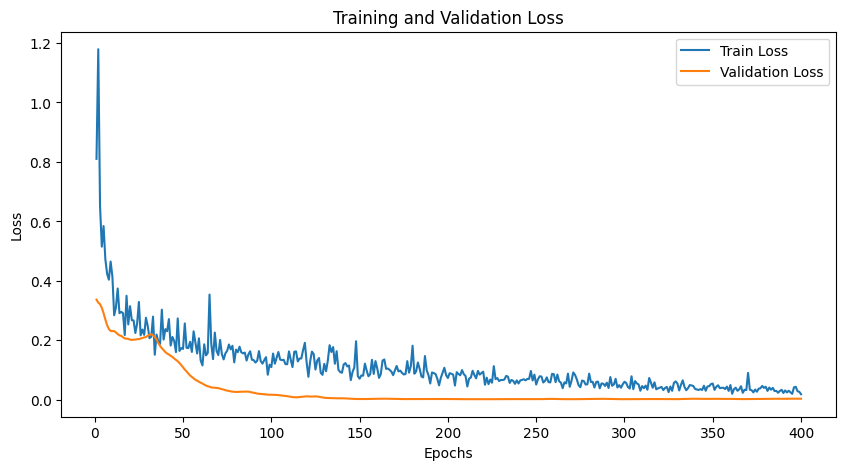

In [21]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_drop_02.pth', 'drop_02.png')

# Dropout = 0.2

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.4216, Train MAE: 0.1789
Val RMSE: 0.3574, Val MAE: 0.3533
Epoch 200/400:
Train RMSE: 0.3527, Train MAE: 0.1330
Val RMSE: 0.2492, Val MAE: 0.2459
Epoch 300/400:
Train RMSE: 0.2458, Train MAE: 0.0994
Val RMSE: 0.1725, Val MAE: 0.1688
Epoch 400/400:
Train RMSE: 0.1694, Train MAE: 0.0807
Val RMSE: 0.1476, Val MAE: 0.1436

Final Results:
Test RMSE: 0.2208
Test MAE: 0.2150


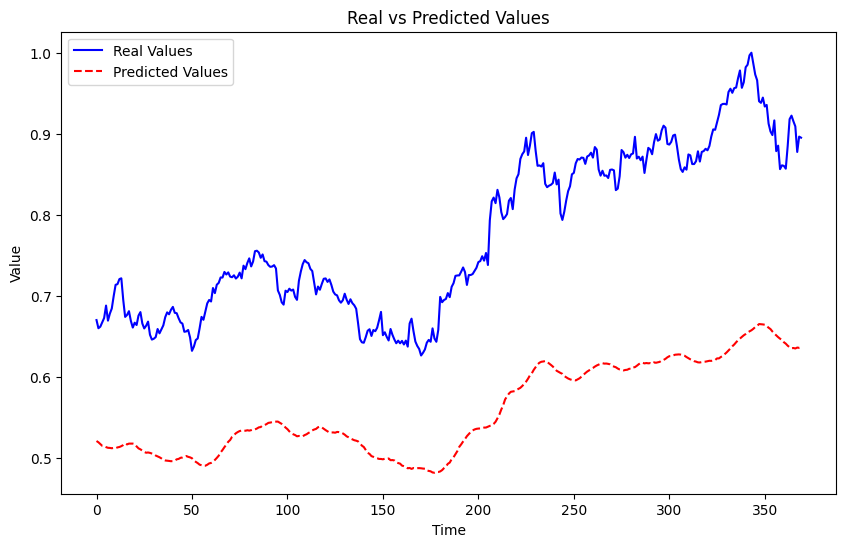

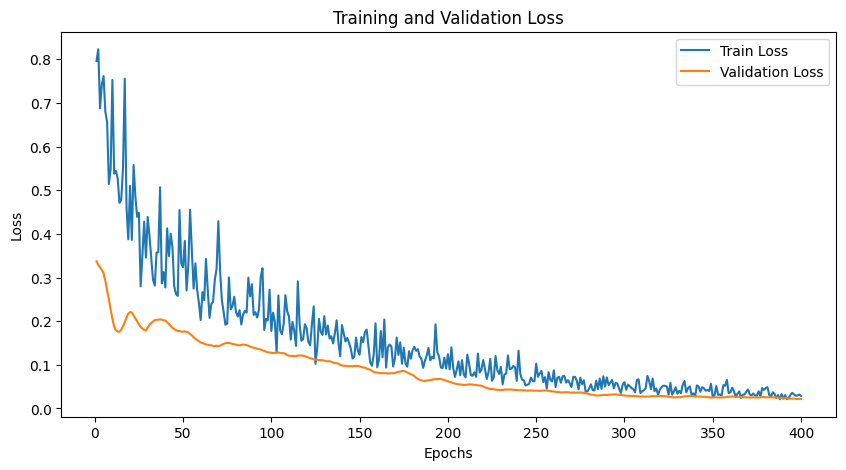

In [22]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.2
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_drop_02.pth', 'drop_02.png')

# Dropout = 0.3

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.5047, Train MAE: 0.2081
Val RMSE: 0.4341, Val MAE: 0.4298
Epoch 200/400:
Train RMSE: 0.3028, Train MAE: 0.1488
Val RMSE: 0.4382, Val MAE: 0.4343
Epoch 300/400:
Train RMSE: 0.2090, Train MAE: 0.1127
Val RMSE: 0.4268, Val MAE: 0.4232
Epoch 400/400:
Train RMSE: 0.1307, Train MAE: 0.0888
Val RMSE: 0.4135, Val MAE: 0.4104

Final Results:
Test RMSE: 0.5156
Test MAE: 0.5124


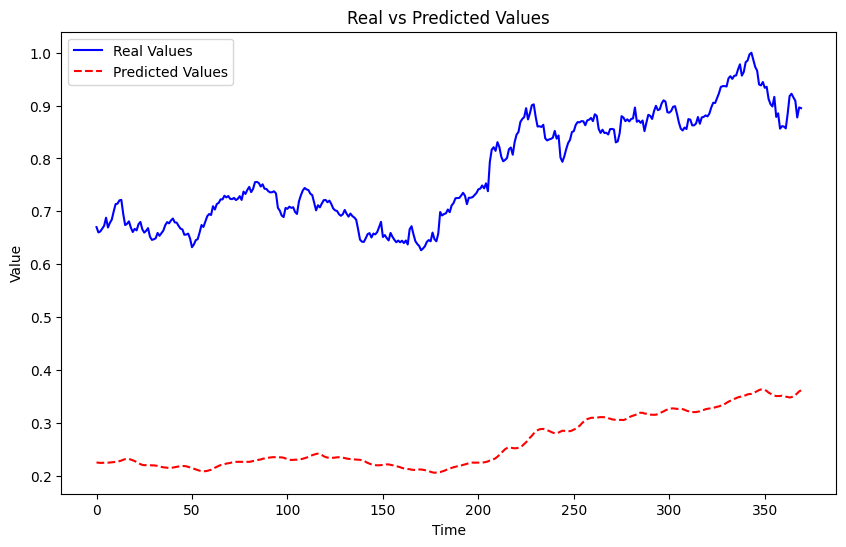

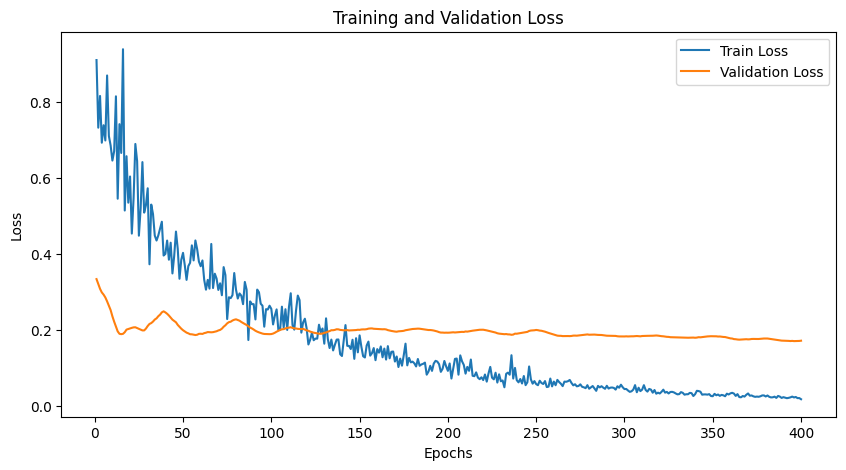

In [23]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.3
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_drop_03.pth', 'drop_03.png')

# Local Drop Path = 0.1

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.4271, Train MAE: 0.1358
Val RMSE: 0.0641, Val MAE: 0.0527
Epoch 200/400:
Train RMSE: 0.3723, Train MAE: 0.1022
Val RMSE: 0.0503, Val MAE: 0.0427
Epoch 300/400:
Train RMSE: 0.2317, Train MAE: 0.0745
Val RMSE: 0.0488, Val MAE: 0.0415
Epoch 400/400:
Train RMSE: 0.2177, Train MAE: 0.0624
Val RMSE: 0.0500, Val MAE: 0.0419

Final Results:
Test RMSE: 0.0985
Test MAE: 0.0848


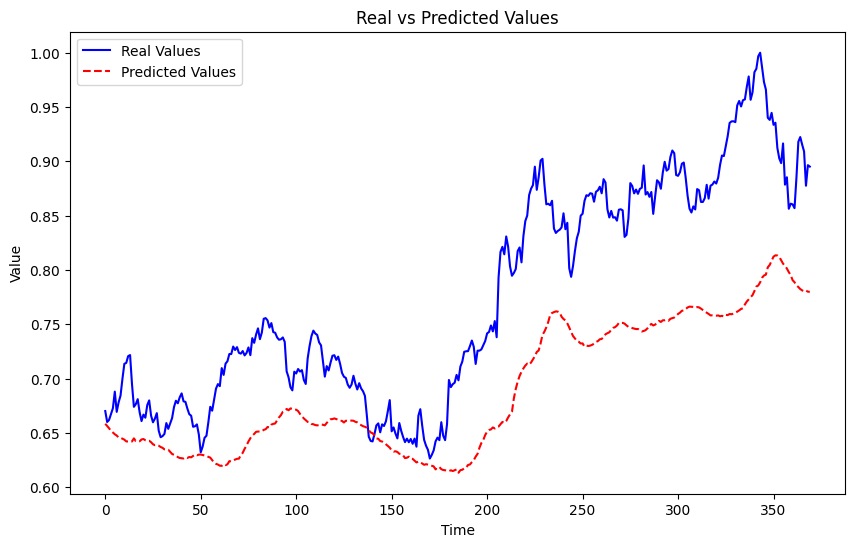

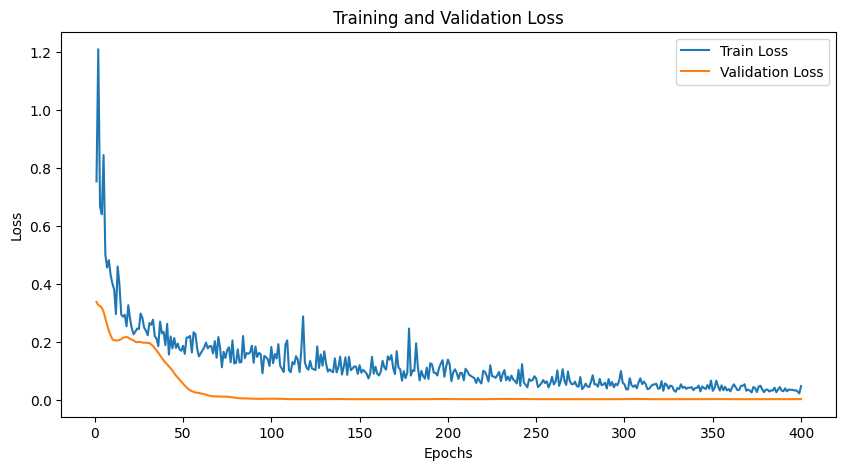

In [24]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.1
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_local_01.pth', 'local_01.png')

# Local Drop Path = 0.2

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3319, Train MAE: 0.1328
Val RMSE: 0.1312, Val MAE: 0.1231
Epoch 200/400:
Train RMSE: 0.2711, Train MAE: 0.1014
Val RMSE: 0.0517, Val MAE: 0.0425
Epoch 300/400:
Train RMSE: 0.2466, Train MAE: 0.0790
Val RMSE: 0.0479, Val MAE: 0.0396
Epoch 400/400:
Train RMSE: 0.1378, Train MAE: 0.0592
Val RMSE: 0.0619, Val MAE: 0.0513

Final Results:
Test RMSE: 0.1173
Test MAE: 0.1067


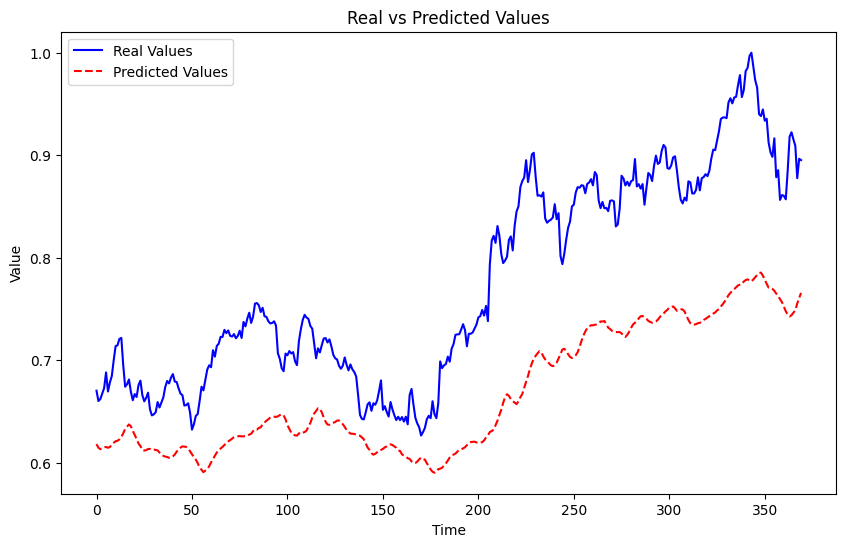

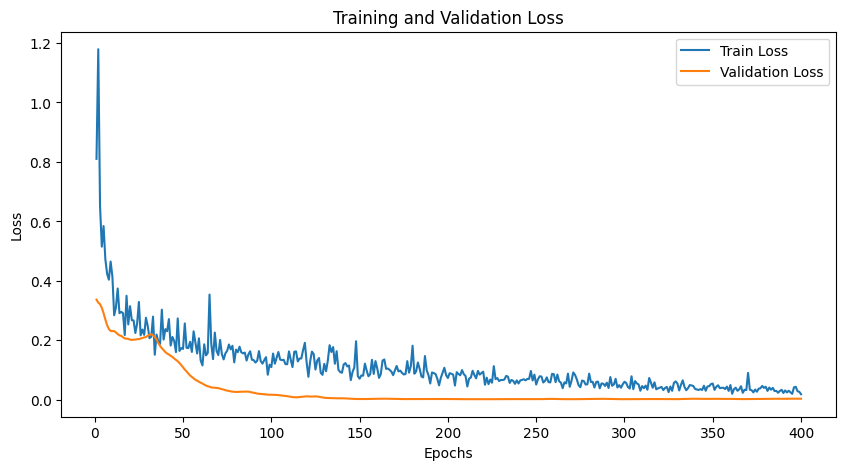

In [25]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_local_03.pth', 'local_03.png')

# Local Drop Path = 0.3

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3241, Train MAE: 0.1331
Val RMSE: 0.2513, Val MAE: 0.2452
Epoch 200/400:
Train RMSE: 0.3134, Train MAE: 0.1068
Val RMSE: 0.1420, Val MAE: 0.1319
Epoch 300/400:
Train RMSE: 0.2792, Train MAE: 0.0902
Val RMSE: 0.0741, Val MAE: 0.0636
Epoch 400/400:
Train RMSE: 0.2195, Train MAE: 0.0746
Val RMSE: 0.0630, Val MAE: 0.0543

Final Results:
Test RMSE: 0.1382
Test MAE: 0.1212


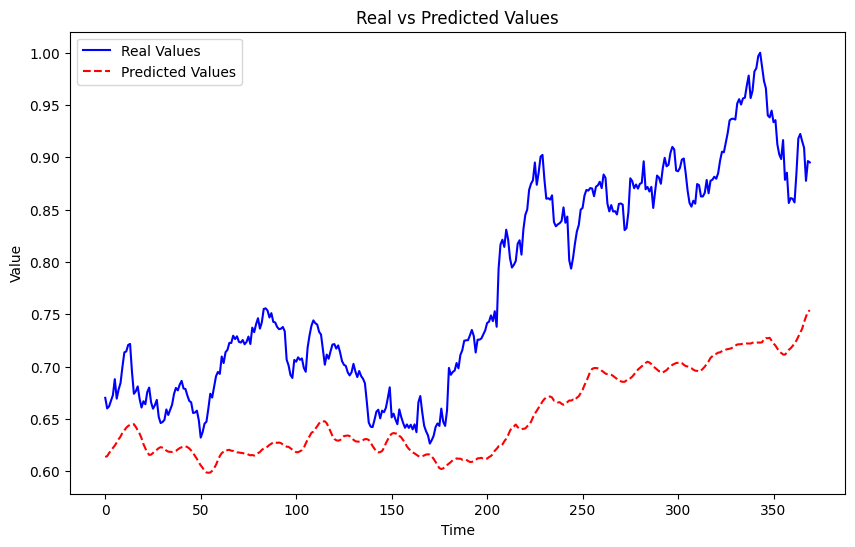

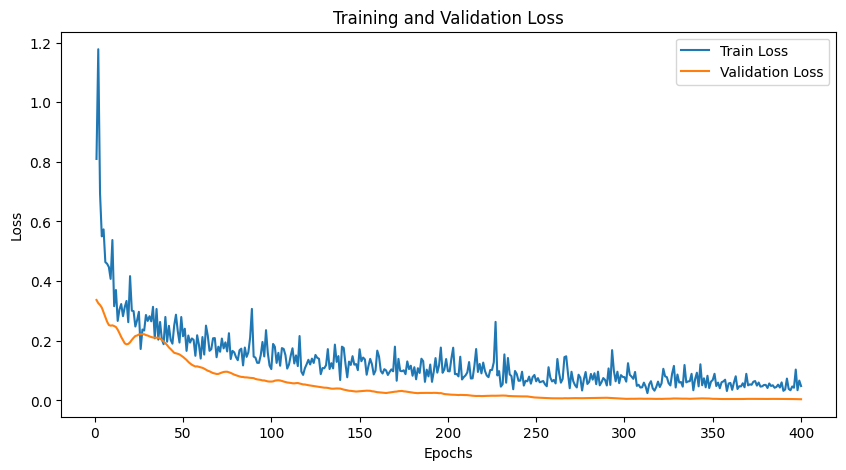

In [26]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_local_03.pth', 'local_03.png')

# Global Drop Path = 0.1

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.4118, Train MAE: 0.1322
Val RMSE: 0.1665, Val MAE: 0.1595
Epoch 200/400:
Train RMSE: 0.2956, Train MAE: 0.0975
Val RMSE: 0.0580, Val MAE: 0.0484
Epoch 300/400:
Train RMSE: 0.2218, Train MAE: 0.0749
Val RMSE: 0.0542, Val MAE: 0.0444
Epoch 400/400:
Train RMSE: 0.2450, Train MAE: 0.0680
Val RMSE: 0.0611, Val MAE: 0.0515

Final Results:
Test RMSE: 0.1345
Test MAE: 0.1174


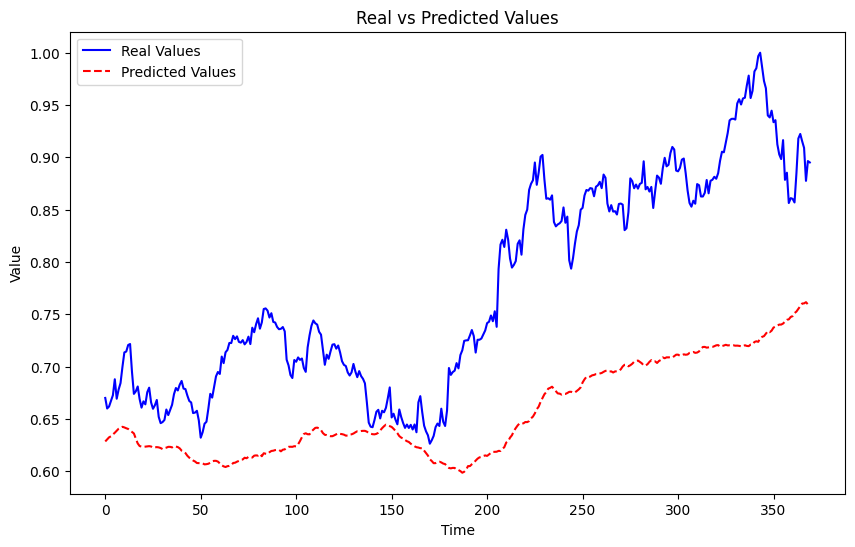

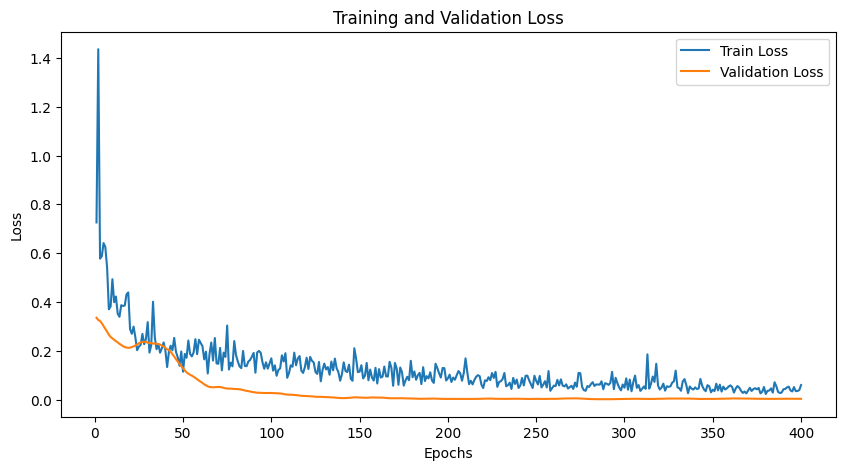

In [27]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.1

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_global_01.pth', 'global_01.png')

# Global Drop Path = 0.3

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/400:
Train RMSE: 0.3856, Train MAE: 0.1461
Val RMSE: 0.1195, Val MAE: 0.1147
Epoch 200/400:
Train RMSE: 0.2792, Train MAE: 0.1047
Val RMSE: 0.0469, Val MAE: 0.0379
Epoch 300/400:
Train RMSE: 0.2305, Train MAE: 0.0834
Val RMSE: 0.0433, Val MAE: 0.0356
Epoch 400/400:
Train RMSE: 0.1767, Train MAE: 0.0687
Val RMSE: 0.0546, Val MAE: 0.0451

Final Results:
Test RMSE: 0.1403
Test MAE: 0.1275


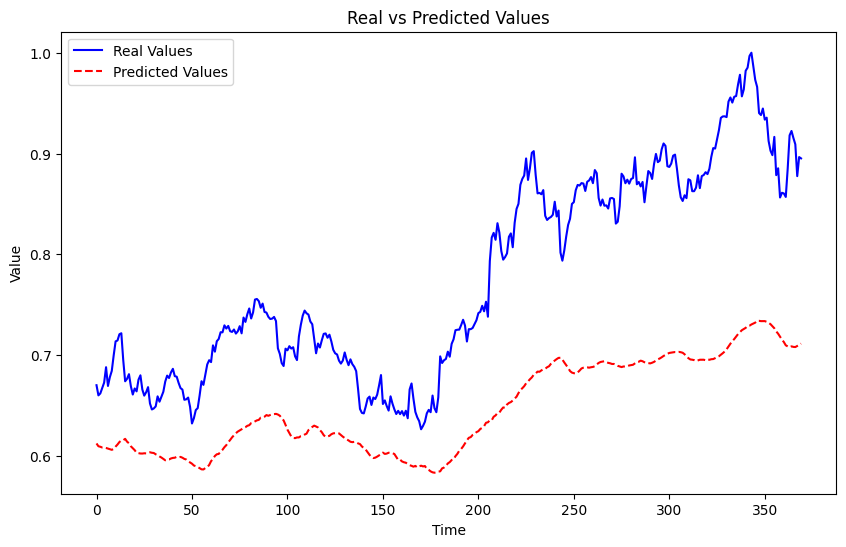

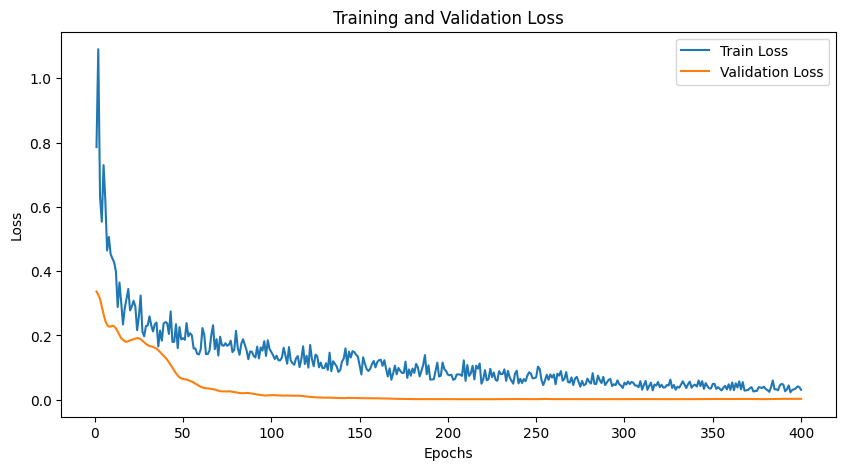

In [29]:
seed_everything(0)
num_epochs = 400
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device,  'fractal_model_global_03.pth', 'global_03.png')

# 800 epoch 

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/800:
Train RMSE: 0.3319, Train MAE: 0.1328
Val RMSE: 0.1312, Val MAE: 0.1231
Epoch 200/800:
Train RMSE: 0.2711, Train MAE: 0.1014
Val RMSE: 0.0517, Val MAE: 0.0425
Epoch 300/800:
Train RMSE: 0.2466, Train MAE: 0.0790
Val RMSE: 0.0479, Val MAE: 0.0396
Epoch 400/800:
Train RMSE: 0.1378, Train MAE: 0.0592
Val RMSE: 0.0619, Val MAE: 0.0513
Epoch 500/800:
Train RMSE: 0.1215, Train MAE: 0.0511
Val RMSE: 0.0625, Val MAE: 0.0527
Epoch 600/800:
Train RMSE: 0.1087, Train MAE: 0.0455
Val RMSE: 0.0671, Val MAE: 0.0580
Epoch 700/800:
Train RMSE: 0.0800, Train MAE: 0.0386
Val RMSE: 0.0596, Val MAE: 0.0518
Epoch 800/800:
Train RMSE: 0.0690, Train MAE: 0.0344
Val RMSE: 0.0714, Val MAE: 0.0643

Final Results:
Test RMSE: 0.1151
Test MAE: 0.1096


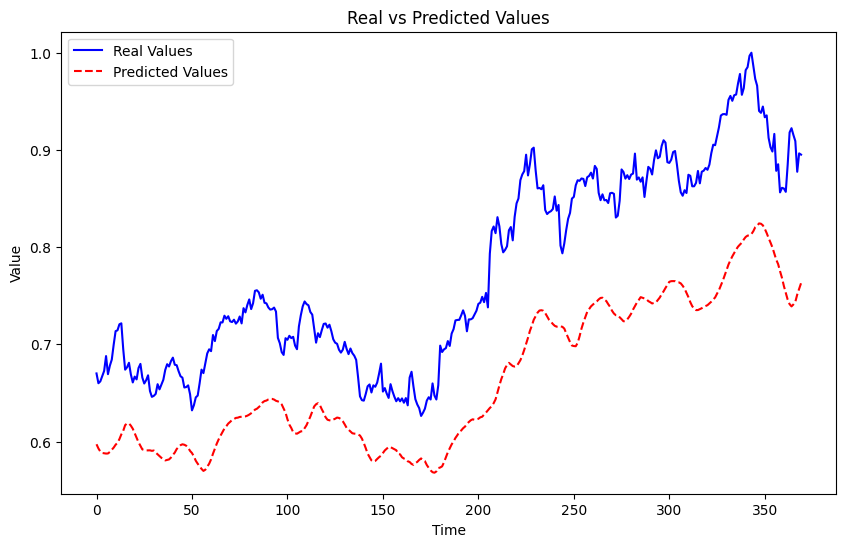

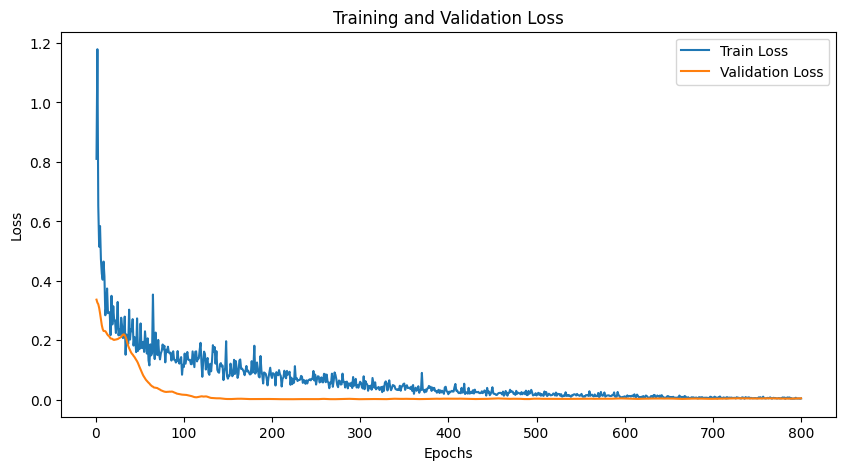

In [30]:
seed_everything(0)
num_epochs = 800
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_800.pth', '800_epoch.png')

# 200 epoch

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24
Epoch 100/200:
Train RMSE: 0.3319, Train MAE: 0.1328
Val RMSE: 0.1312, Val MAE: 0.1231
Epoch 200/200:
Train RMSE: 0.2711, Train MAE: 0.1014
Val RMSE: 0.0517, Val MAE: 0.0425

Final Results:
Test RMSE: 0.1308
Test MAE: 0.1153


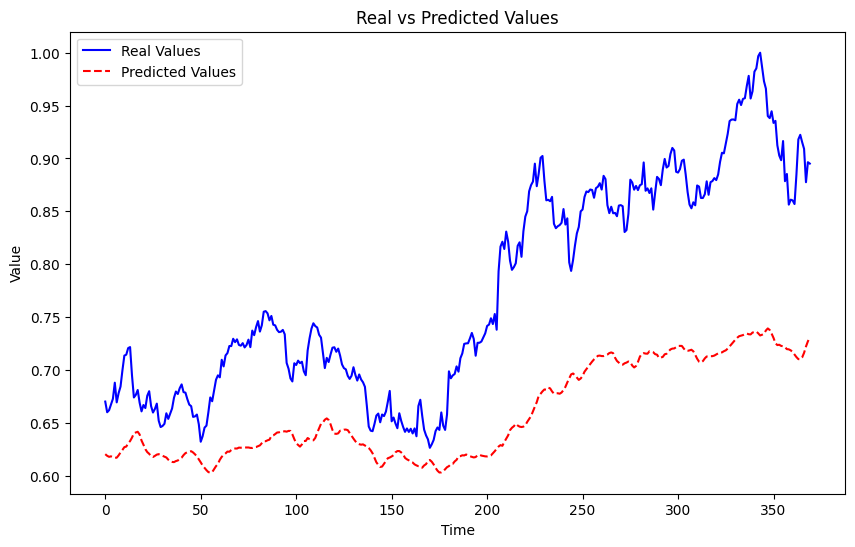

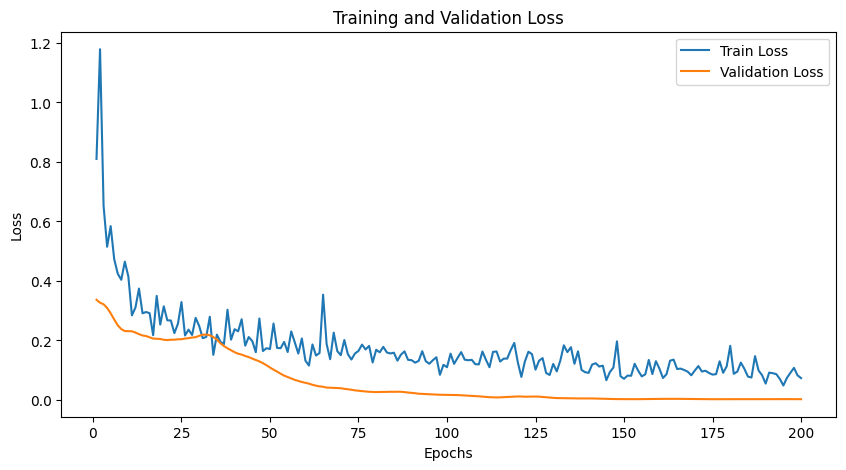

In [31]:
seed_everything(0)
num_epochs = 200
n_blocks = 3
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_800.pth', '800_epoch.png')

# Fractal Block = 4

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Block 4, Input channels: 128, Output channels: 256
Total layers in network: 32
Epoch 100/400:
Train RMSE: 0.5825, Train MAE: 0.2044
Val RMSE: 0.3919, Val MAE: 0.3878
Epoch 200/400:
Train RMSE: 0.4700, Train MAE: 0.1432
Val RMSE: 0.1865, Val MAE: 0.1808
Epoch 300/400:
Train RMSE: 0.2838, Train MAE: 0.1089
Val RMSE: 0.0805, Val MAE: 0.0668
Epoch 400/400:
Train RMSE: 0.2113, Train MAE: 0.0871
Val RMSE: 0.0810, Val MAE: 0.0673

Final Results:
Test RMSE: 0.1980
Test MAE: 0.1843


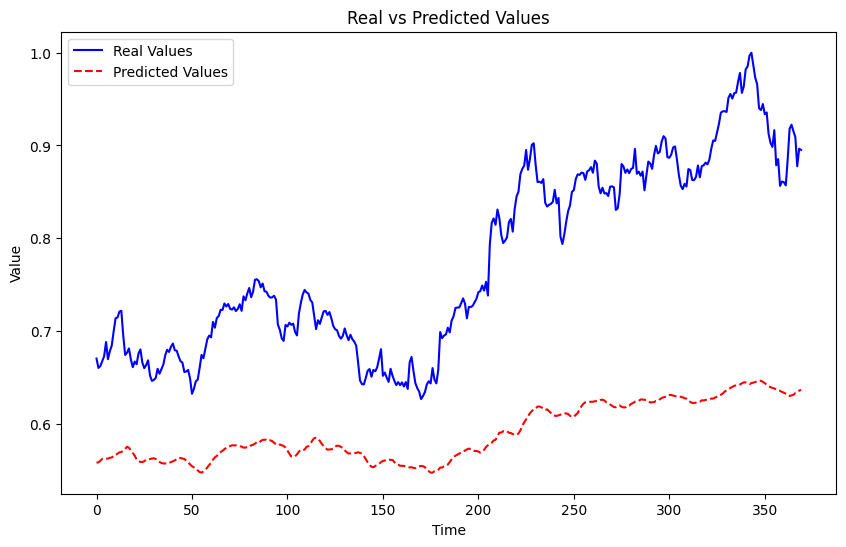

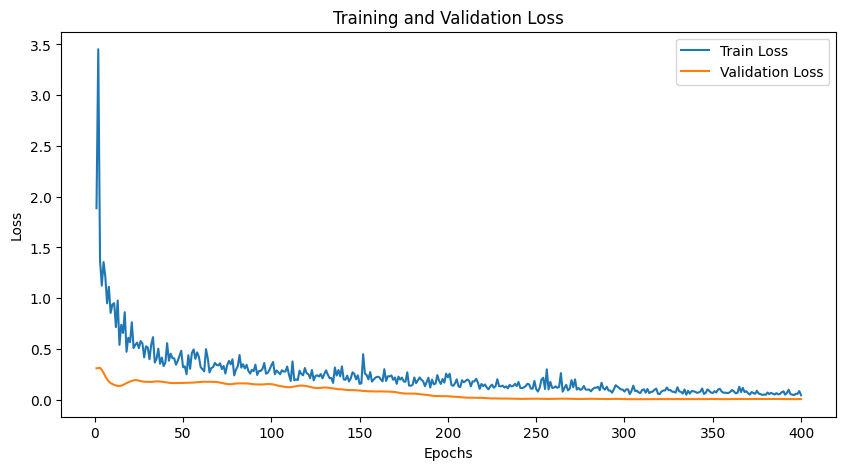

In [32]:
seed_everything(0)
num_epochs = 400
n_blocks = 4
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128, 256)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_4_block.pth', '4_block.png')

Block 1, Input channels: 11, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Block 4, Input channels: 128, Output channels: 256
Total layers in network: 32
Epoch 100/800:
Train RMSE: 0.5825, Train MAE: 0.2044
Val RMSE: 0.3919, Val MAE: 0.3878
Epoch 200/800:
Train RMSE: 0.4700, Train MAE: 0.1432
Val RMSE: 0.1865, Val MAE: 0.1808
Epoch 300/800:
Train RMSE: 0.2838, Train MAE: 0.1089
Val RMSE: 0.0805, Val MAE: 0.0668
Epoch 400/800:
Train RMSE: 0.2113, Train MAE: 0.0871
Val RMSE: 0.0810, Val MAE: 0.0673
Epoch 500/800:
Train RMSE: 0.1599, Train MAE: 0.0714
Val RMSE: 0.0920, Val MAE: 0.0795
Epoch 600/800:
Train RMSE: 0.1305, Train MAE: 0.0628
Val RMSE: 0.0948, Val MAE: 0.0829
Epoch 700/800:
Train RMSE: 0.1171, Train MAE: 0.0567
Val RMSE: 0.0903, Val MAE: 0.0784
Epoch 800/800:
Train RMSE: 0.0890, Train MAE: 0.0482
Val RMSE: 0.0875, Val MAE: 0.0756

Final Results:
Test RMSE: 0.2040
Test MAE: 0.1922


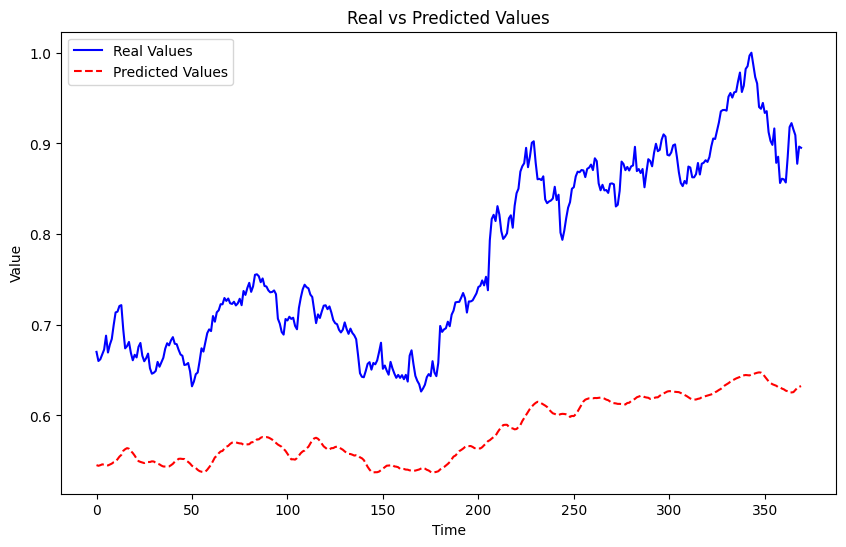

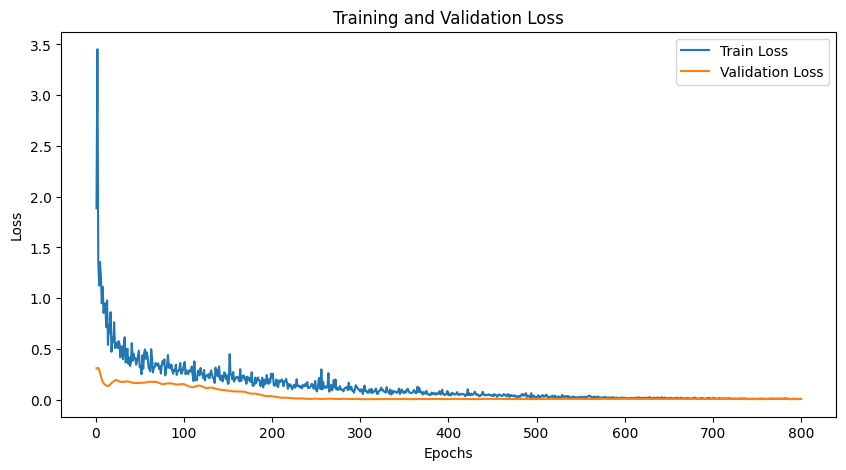

In [33]:
seed_everything(0)
num_epochs = 800
n_blocks = 4
n_columns = 4
in_channels = 11
out_channels = (32, 64, 128, 256)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.2
global_drop_prob = 0.2

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_4_block.pth', '4_block.png')

# Fractal Block = 2

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2357, Train MAE: 0.1070
Val RMSE: 0.0419, Val MAE: 0.0324
Epoch 200/400:
Train RMSE: 0.1991, Train MAE: 0.0738
Val RMSE: 0.0270, Val MAE: 0.0219
Epoch 300/400:
Train RMSE: 0.1239, Train MAE: 0.0602
Val RMSE: 0.0453, Val MAE: 0.0393
Epoch 400/400:
Train RMSE: 0.1305, Train MAE: 0.0455
Val RMSE: 0.0270, Val MAE: 0.0234

Final Results:
Test RMSE: 0.0309
Test MAE: 0.0254


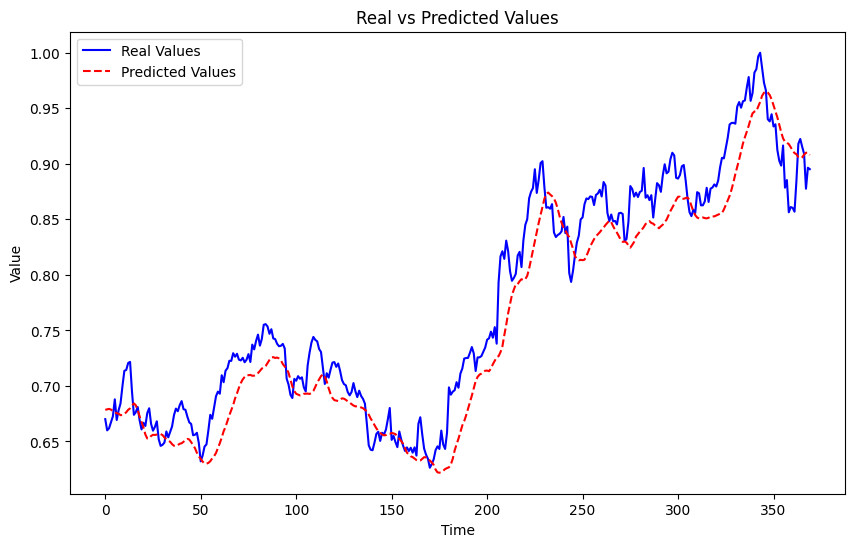

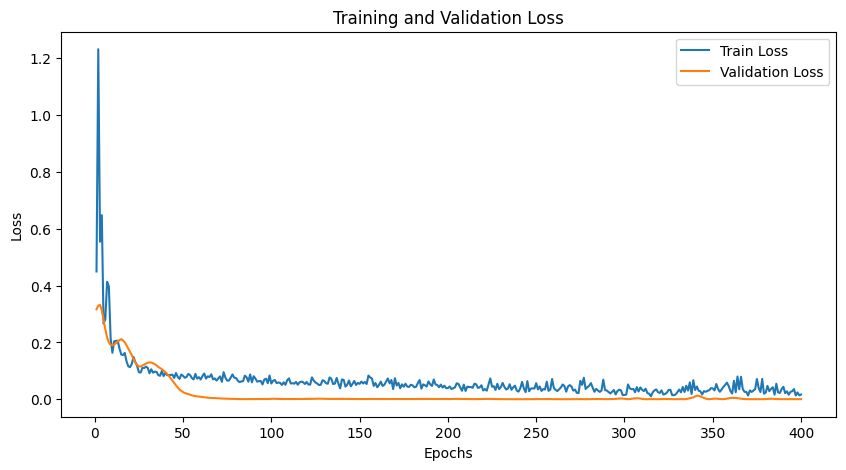

In [34]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', SEQUENCE_LENGTH, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_2_block.pth', '2_block.png')

# **time step = 5**

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.3113, Train MAE: 0.1278
Val RMSE: 0.0768, Val MAE: 0.0706
Epoch 200/400:
Train RMSE: 0.2492, Train MAE: 0.0924
Val RMSE: 0.0319, Val MAE: 0.0268
Epoch 300/400:
Train RMSE: 0.1955, Train MAE: 0.0699
Val RMSE: 0.0377, Val MAE: 0.0313
Epoch 400/400:
Train RMSE: 0.1953, Train MAE: 0.0572
Val RMSE: 0.0251, Val MAE: 0.0214

Final Results:
Test RMSE: 0.0425
Test MAE: 0.0366


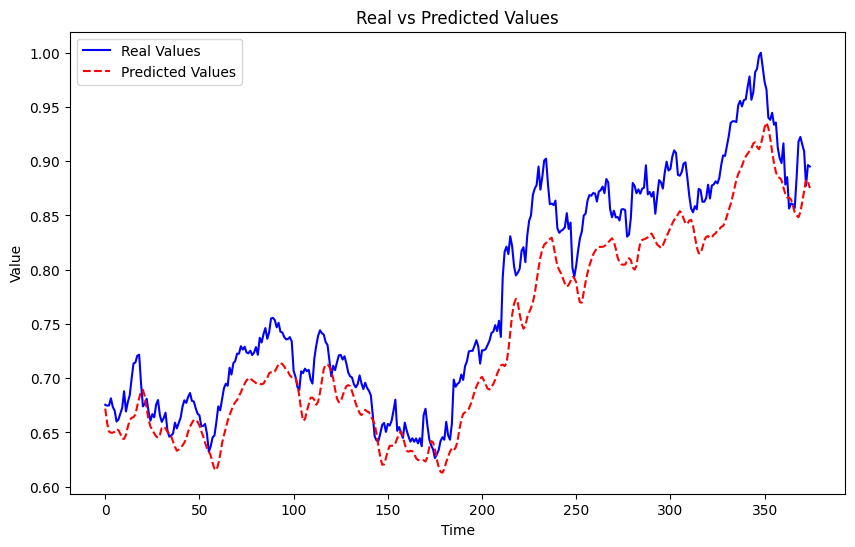

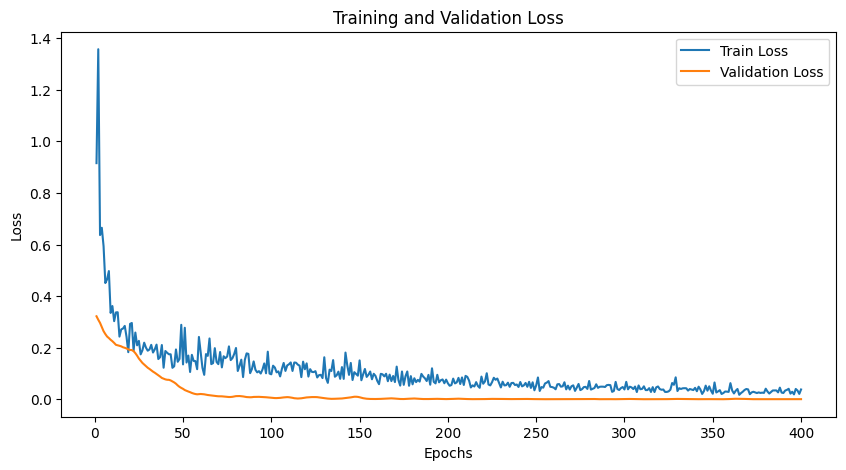

In [41]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 5, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_step_5.pth', 'step_5.png')

# **time step = 10**

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.2357, Train MAE: 0.1070
Val RMSE: 0.0419, Val MAE: 0.0324
Epoch 200/400:
Train RMSE: 0.1991, Train MAE: 0.0738
Val RMSE: 0.0270, Val MAE: 0.0219
Epoch 300/400:
Train RMSE: 0.1239, Train MAE: 0.0602
Val RMSE: 0.0453, Val MAE: 0.0393
Epoch 400/400:
Train RMSE: 0.1305, Train MAE: 0.0455
Val RMSE: 0.0270, Val MAE: 0.0234

Final Results:
Test RMSE: 0.0309
Test MAE: 0.0254


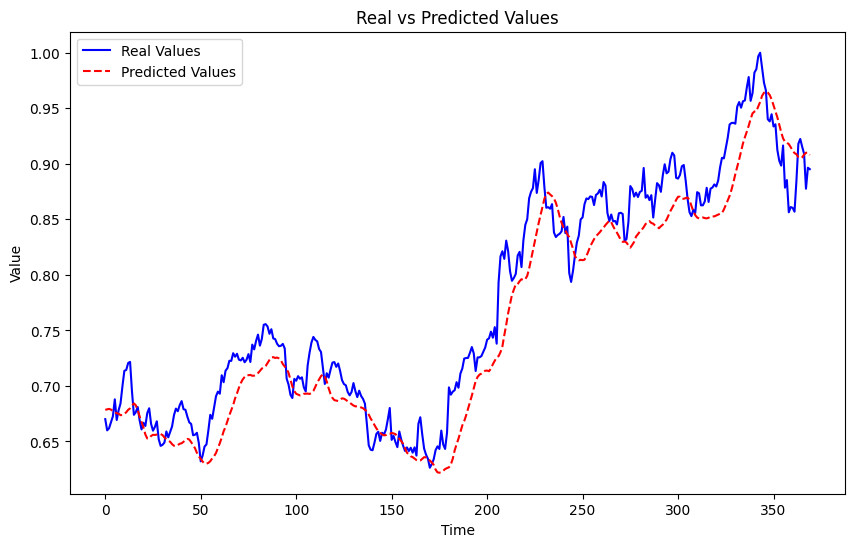

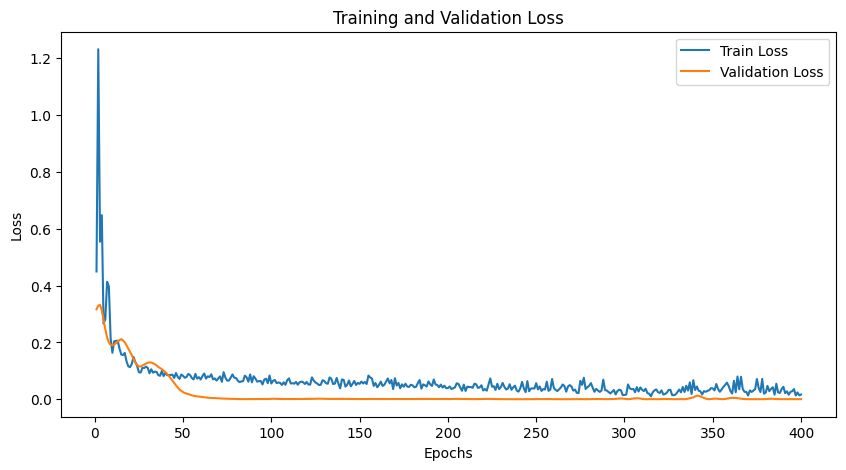

In [53]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_step_10.pth', 'step_10.png')

# **time step = 20**

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.1987, Train MAE: 0.0890
Val RMSE: 0.0919, Val MAE: 0.0865
Epoch 200/400:
Train RMSE: 0.1816, Train MAE: 0.0710
Val RMSE: 0.0608, Val MAE: 0.0525
Epoch 300/400:
Train RMSE: 0.1468, Train MAE: 0.0516
Val RMSE: 0.0294, Val MAE: 0.0222
Epoch 400/400:
Train RMSE: 0.1304, Train MAE: 0.0451
Val RMSE: 0.0404, Val MAE: 0.0336

Final Results:
Test RMSE: 0.0824
Test MAE: 0.0766


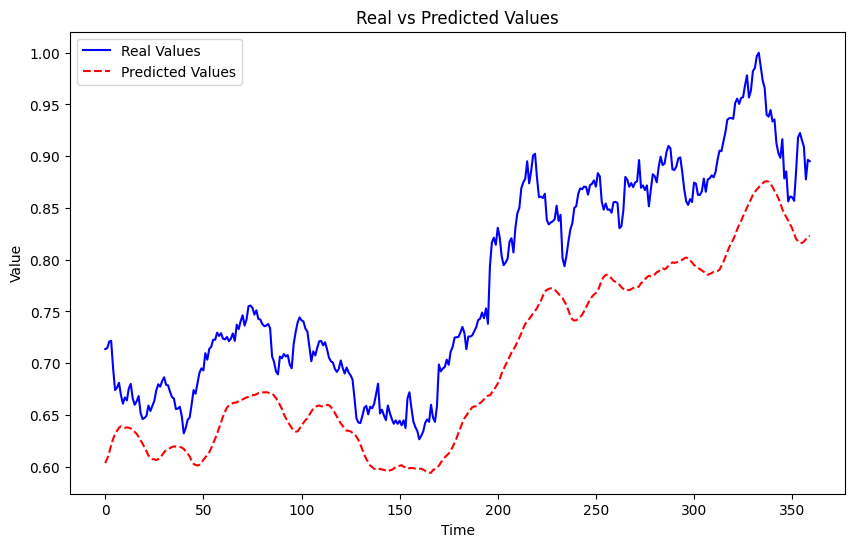

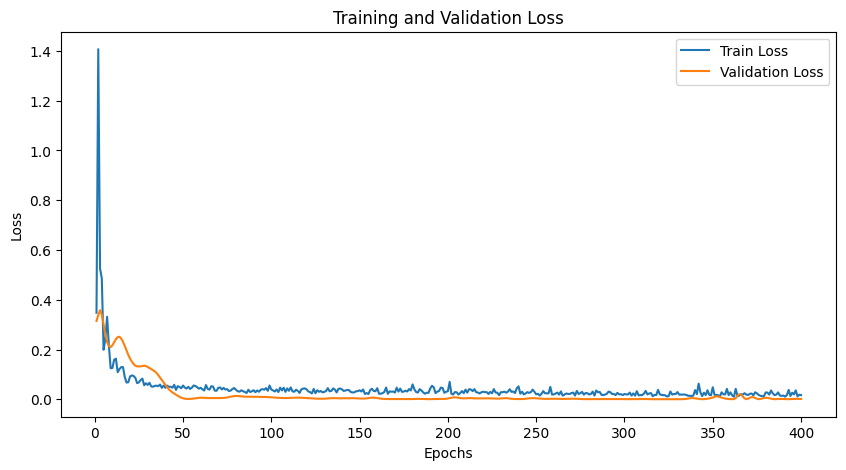

In [55]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 11
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_step_20.pth', 'step_20.png')

# Data with macro indexes

In [63]:
columns = ['Open', 'High', 'Low', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD',
       'MACD_Signal', 'BB_Upper', 'BB_Lower', '10Y_Treasury_Yield', 'VIX',
       'DXY_Index', 'Brent_Crude_Oil', 'WTI_Crude_Oil', 'Gold', 'GDP', 'CPI',
       'PPI', 'Fed_Funds_Rate', 'M2_Money_Supply', 'Unemployment_Rate',
       'Initial_Jobless_Claims', 'Consumer_Confidence_Index', 'Trade_Balance']
data_macro_index = pd.read_csv('/kaggle/input/macro-indexes/data_with_full_indexes.csv')
stock_data = preprocessing(data_macro_index)

<ipython-input-3-86a397dbe36d>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-86a397dbe36d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


Block 1, Input channels: 26, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.3436, Train MAE: 0.1382
Val RMSE: 0.1179, Val MAE: 0.1061
Epoch 200/400:
Train RMSE: 0.3102, Train MAE: 0.0936
Val RMSE: 0.0509, Val MAE: 0.0400
Epoch 300/400:
Train RMSE: 0.2231, Train MAE: 0.0712
Val RMSE: 0.0436, Val MAE: 0.0344
Epoch 400/400:
Train RMSE: 0.1583, Train MAE: 0.0533
Val RMSE: 0.0377, Val MAE: 0.0294

Final Results:
Test RMSE: 0.1070
Test MAE: 0.0994


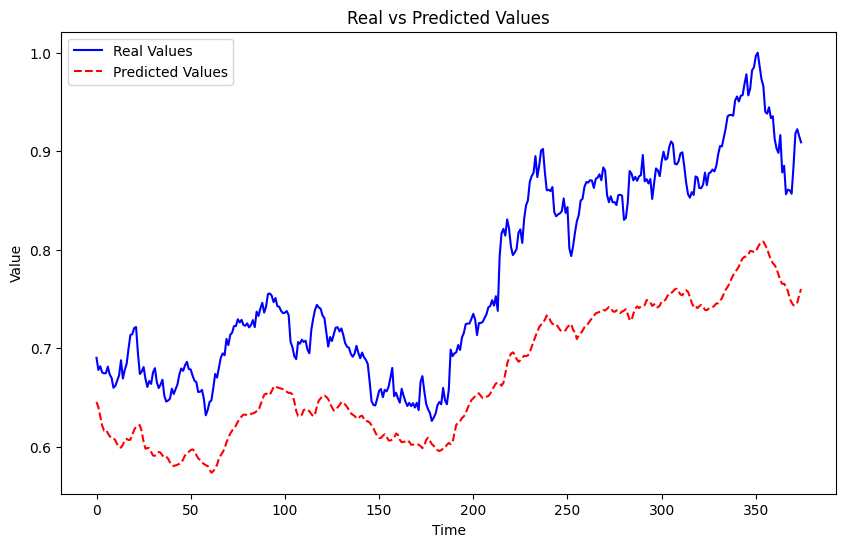

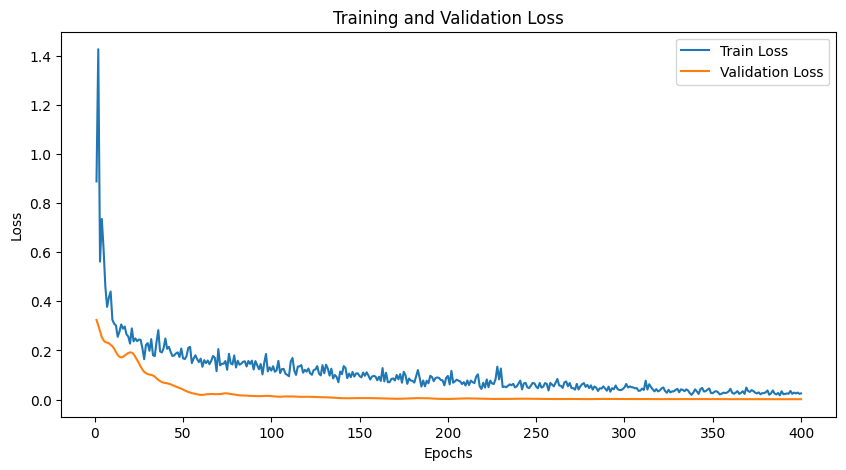

In [64]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 26
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(stock_data, columns, 'Close', 5, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_macro_step_5.pth', 'macro_step_5.png')

Block 1, Input channels: 26, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.3830, Train MAE: 0.1099
Val RMSE: 0.0813, Val MAE: 0.0672
Epoch 200/400:
Train RMSE: 0.2889, Train MAE: 0.0798
Val RMSE: 0.0612, Val MAE: 0.0491
Epoch 300/400:
Train RMSE: 0.2150, Train MAE: 0.0609
Val RMSE: 0.0595, Val MAE: 0.0459
Epoch 400/400:
Train RMSE: 0.1551, Train MAE: 0.0506
Val RMSE: 0.0468, Val MAE: 0.0366

Final Results:
Test RMSE: 0.1004
Test MAE: 0.0961


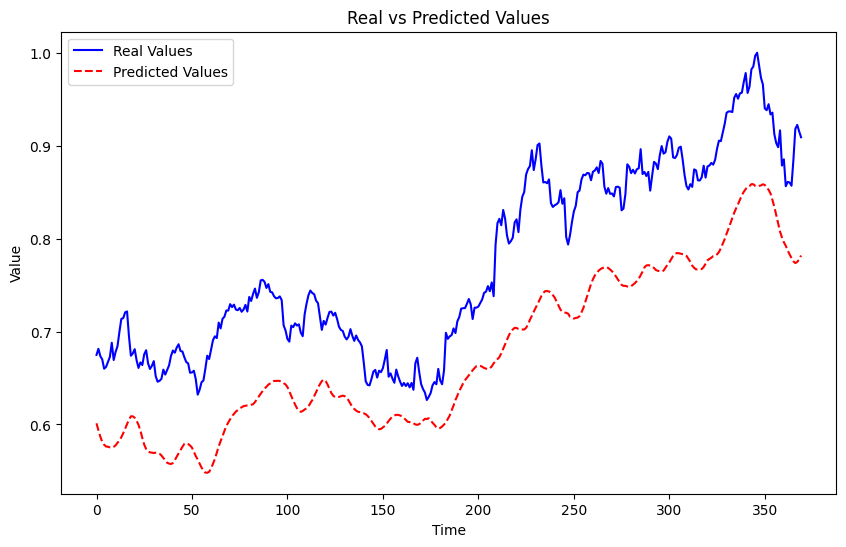

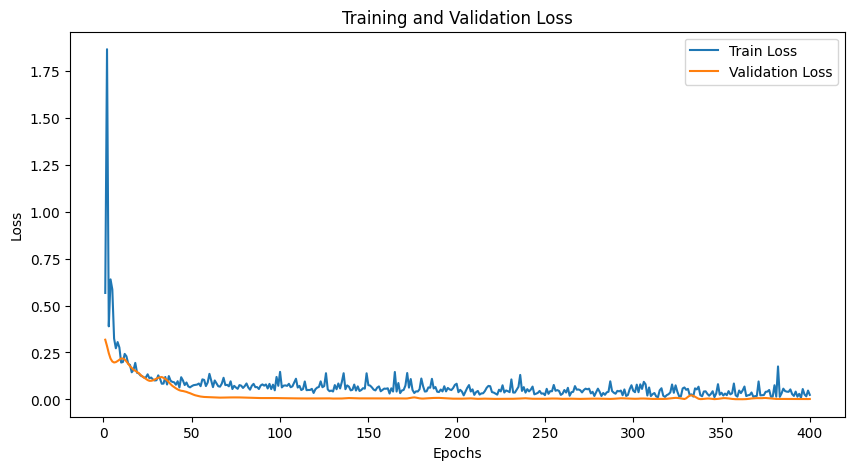

In [65]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 26
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(stock_data, columns, 'Close', 10, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_macro_step_10.pth', 'macro_step_10.png')

Block 1, Input channels: 26, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.1919, Train MAE: 0.0920
Val RMSE: 0.0879, Val MAE: 0.0749
Epoch 200/400:
Train RMSE: 0.1612, Train MAE: 0.0616
Val RMSE: 0.0557, Val MAE: 0.0474
Epoch 300/400:
Train RMSE: 0.1473, Train MAE: 0.0607
Val RMSE: 0.0421, Val MAE: 0.0348
Epoch 400/400:
Train RMSE: 0.1423, Train MAE: 0.0408
Val RMSE: 0.0618, Val MAE: 0.0548

Final Results:
Test RMSE: 0.0697
Test MAE: 0.0611


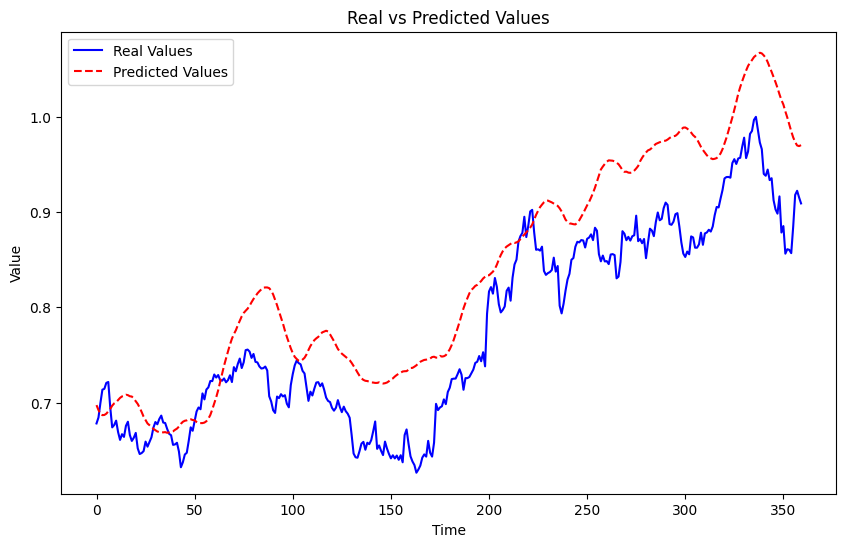

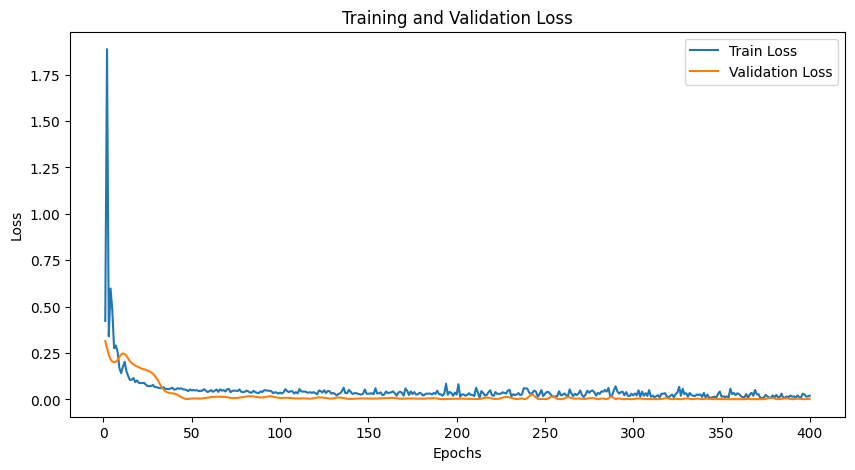

In [66]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 26
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(stock_data, columns, 'Close', 20, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_macro_step_20.pth', 'macro_step_20.png')

In [67]:
data_macro_index = pd.read_csv('/kaggle/input/macro-indexes/data_with_some_indexes.csv')
data_macro_index.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EMA', 'RSI',
       'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower', 'Fed_Funds_Rate',
       'DXY_Index', 'Trade_Balance', 'Unemployment_Rate', 'CPI', 'GDP',
       'M2_Money_Supply_Lagged', 'PPI', 'Gold'],
      dtype='object')

In [68]:
columns = ['Open', 'High', 'Low', 'Volume', 'SMA', 'EMA', 'RSI',
       'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower', 'Fed_Funds_Rate',
       'DXY_Index', 'Trade_Balance', 'Unemployment_Rate', 'CPI', 'GDP',
       'M2_Money_Supply_Lagged', 'PPI', 'Gold']
data_macro_index = pd.read_csv('/kaggle/input/macro-indexes/data_with_some_indexes.csv')
stock_data = preprocessing(data_macro_index)

<ipython-input-3-86a397dbe36d>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-86a397dbe36d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


Block 1, Input channels: 20, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.3705, Train MAE: 0.1703
Val RMSE: 0.0430, Val MAE: 0.0341
Epoch 200/400:
Train RMSE: 0.3399, Train MAE: 0.1268
Val RMSE: 0.0475, Val MAE: 0.0408
Epoch 300/400:
Train RMSE: 0.2264, Train MAE: 0.0876
Val RMSE: 0.0436, Val MAE: 0.0370
Epoch 400/400:
Train RMSE: 0.1812, Train MAE: 0.0671
Val RMSE: 0.0398, Val MAE: 0.0335

Final Results:
Test RMSE: 0.0524
Test MAE: 0.0432


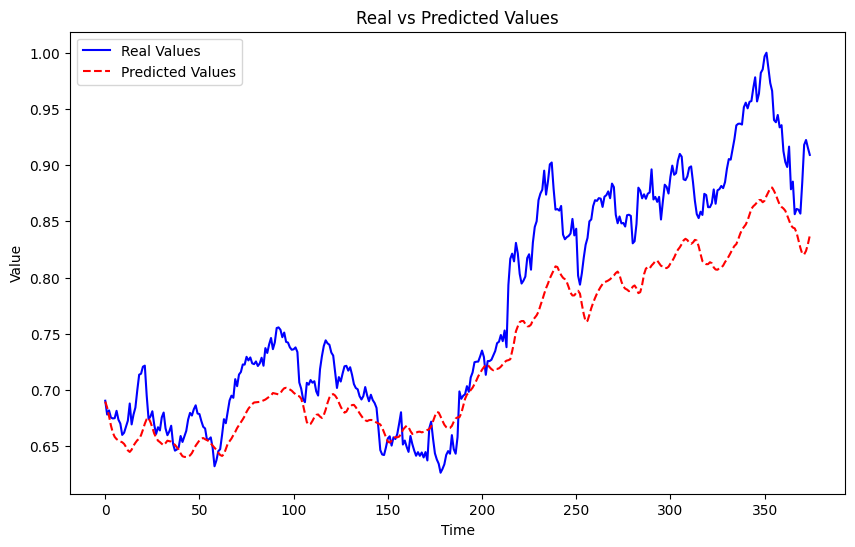

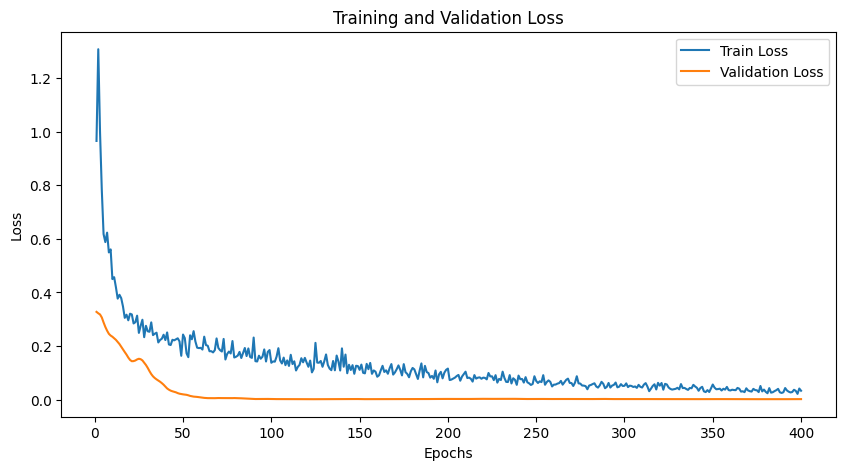

In [69]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 20
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(stock_data, columns, 'Close', 5, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_macro_some_step_5.pth', 'macro_some_step_5.png')

Block 1, Input channels: 20, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.3142, Train MAE: 0.1252
Val RMSE: 0.1052, Val MAE: 0.0979
Epoch 200/400:
Train RMSE: 0.2357, Train MAE: 0.0896
Val RMSE: 0.0862, Val MAE: 0.0804
Epoch 300/400:
Train RMSE: 0.2059, Train MAE: 0.0609
Val RMSE: 0.0382, Val MAE: 0.0303
Epoch 400/400:
Train RMSE: 0.1592, Train MAE: 0.0543
Val RMSE: 0.0464, Val MAE: 0.0396

Final Results:
Test RMSE: 0.0383
Test MAE: 0.0319


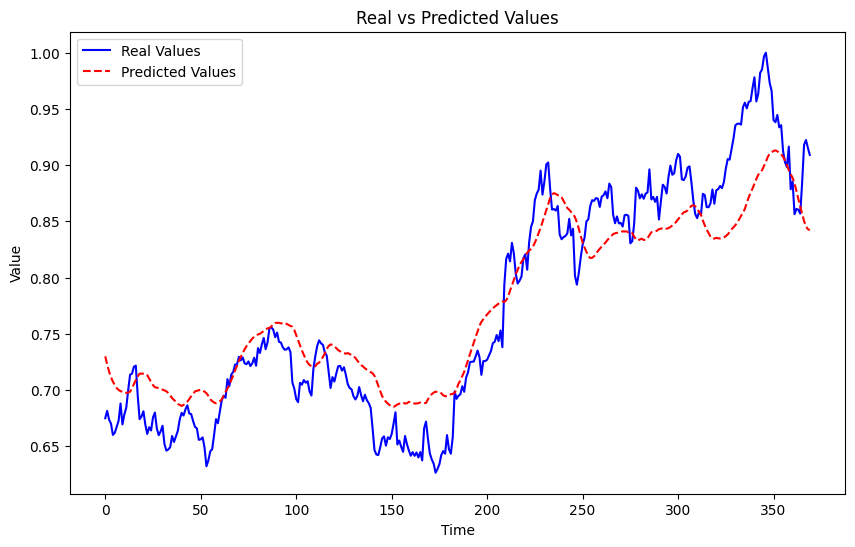

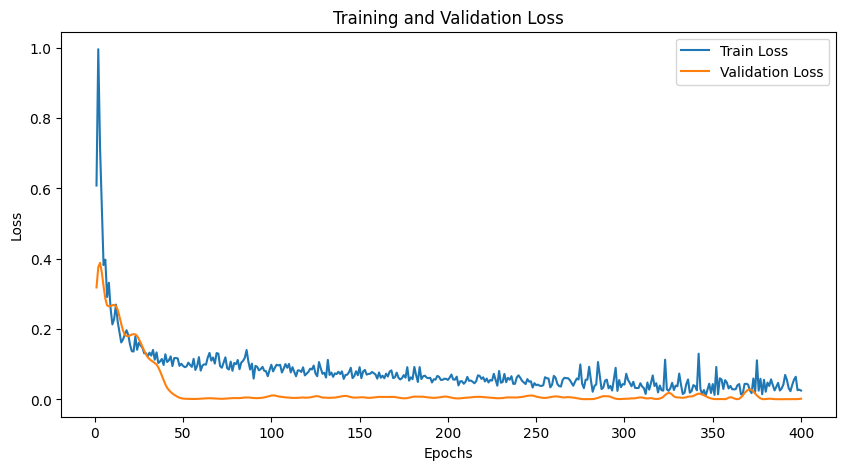

In [70]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 20
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(stock_data, columns, 'Close', 10, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_macro_some_step_10.pth', 'macro_some_step_10.png')

Block 1, Input channels: 20, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total layers in network: 16
Epoch 100/400:
Train RMSE: 0.1862, Train MAE: 0.0949
Val RMSE: 0.1733, Val MAE: 0.1638
Epoch 200/400:
Train RMSE: 0.1706, Train MAE: 0.0757
Val RMSE: 0.0629, Val MAE: 0.0549
Epoch 300/400:
Train RMSE: 0.1537, Train MAE: 0.0614
Val RMSE: 0.0731, Val MAE: 0.0571
Epoch 400/400:
Train RMSE: 0.1126, Train MAE: 0.0440
Val RMSE: 0.0463, Val MAE: 0.0380

Final Results:
Test RMSE: 0.0629
Test MAE: 0.0555


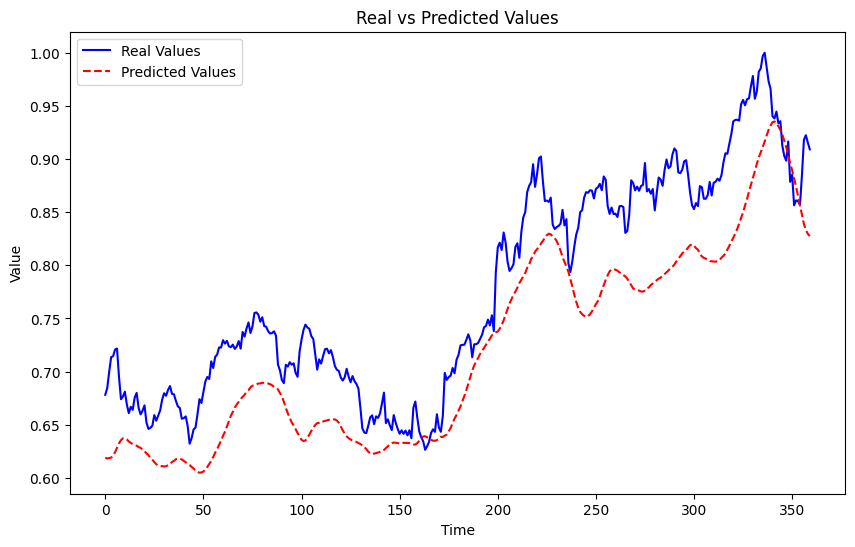

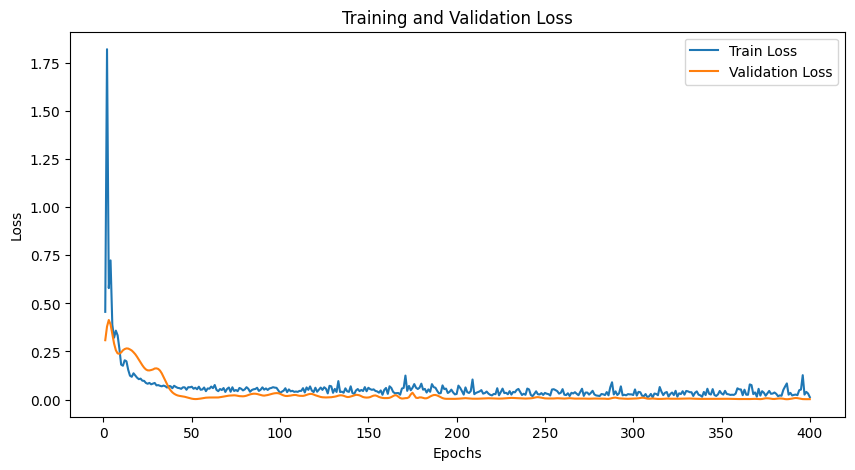

In [73]:
seed_everything(0)
num_epochs = 400
n_blocks = 2
n_columns = 4
in_channels = 20
out_channels = (64, 128)
kernel_size = 3
drop_prob = 0.1
local_drop_prob = 0.3
global_drop_prob = 0.3

model = FractalNet(n_blocks, n_columns, in_channels, out_channels, kernel_size, local_drop_prob, drop_prob, global_drop_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(stock_data, columns, 'Close', 20, 64)
train_and_evaluate(train_dataloader, val_dataloader, test_dataloader, targets, model, criterion, optimizer, num_epochs, device, 'fractal_model_macro_some_step_20.pth', 'macro_some_step_20.png')